# Recurrent Neural Networks - IMDB Movie Reviews

In this exercise, we'll train LSTM models for sentiment classification on the IMDB dataset. LSTMs are recurrent neural networks = they feed their (intermediate) outputs or states back into themselves **as it processes a sequence**. All previous NNs we looked at had static and fixed-size inputs, RNNs can process sequences of variable length. 

The Long-Short-Term-Memory Cells (LSTM) by Hochreiter et al, "fix" the massive vanishing gradient issue of RNNs by using a stable cell state that allows backprop to work even over long sequences. (Consider looking at lecture notes if this is unclear still)

Todays Example Implementation of LSTM will be for
**Dataset**: IMDB Movie Review Sentiment Classification from [keras.datasets](https://keras.io/api/datasets/imdb/)  
**Task**: Binary classification (positive/negative sentiment)

## 1. Setup and Imports

In [34]:
import numpy as np
import keras
from utils import (
    load_imdb_data,
    create_embedding_matrix_from_glove,
    download_glove_embeddings,
    train_model,
    eval_binary_classification,
    compare_models,
    plot_training_history
)

### Lets talk about words
Because we want to train on text, we first have to think about how we are going to accomplish a **numeric** representation of text. 
- a simple way to do this is to first split or tokenize data, lets say by words 
- then each unique word in our vocabulary (eg. english language) is represented by a unique integer

- A single integer however cant carry a lot of meaning at all and its fixed at init; we would like a representation of the word that can compress its meaning in accordance of our goal. 
This is often a (more or less) high dimensional vector representation, that can be learned during training. We will later see that we can also use pretrained static word embeddings.

Hint: The idea of learning a "latent" vector representation (compression) of some concept or thing in our data is **essential** to all of deep learning.

In [ ]:

MAX_WORDS = 10000      # Vocabulary size, any unique words over that limit in the dataset are masked (rarest first)
MAX_LEN = 500          # Maximum sequence length (limit the max length of a review)
EMBEDDING_DIM = 100    # Embedding dimension, compressing from a 10k space (vocab size) into a task specific 100-dimensional latent space
LSTM_UNITS = 100       # LSTM hidden units (size of hidden state vectors)
BATCH_SIZE = 64       
EPOCHS = 10          

## 2. Lets Load IMDB Dataset

We use `keras.datasets.imdb` whhich provides pre-processed movie reviews. The dataset contains 25,000 training and 25,000 test reviews, labeled by sentiment (positive/negative).

In [36]:
X_train, y_train, X_val, y_val, X_test, y_test, word_index = load_imdb_data(
    num_words=MAX_WORDS,
    maxlen=MAX_LEN,
    test_split=0.5
)

Training samples:   25,000
Validation samples: 12,500
Test samples:       12,500
Vocabulary size:    10,000
Sequence length:    500


In [ ]:
#how each word or token is mapped to a unique integer
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [37]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nFirst training sample (word indices):")
print(X_train[0][:50], "...")

X_train shape: (25000, 500)
y_train shape: (25000,)

First training sample (word indices):
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447] ...


In [38]:
reverse_word_index = {v + 3: k for k, v in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<OOV>'

def decode_review(encoded):
    return ' '.join(reverse_word_index.get(i, '<?>') for i in encoded if i != 0)

print("Sample review:")
print(decode_review(X_train[0])[:500], "...")
print(f"\nLabel: {'Positive' if y_train[0] == 1 else 'Negative'}")

Sample review:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would re ...

Label: Positive


## 3. Model 1: LSTM with Trained Embeddings from scratch

First, we train an LSTM with a trainable `Embedding` layer that learns word representations from scratch during training.

In [ ]:
model_trainable = keras.models.Sequential([
    keras.layers.Input(shape=(MAX_LEN,)),
    keras.layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True  # lstm can deal with variable length inputs! (we padded to have nice tensors as initial input)
    ),
    keras.layers.LSTM(LSTM_UNITS),
    keras.layers.Dense(1, activation='sigmoid')
])

model_trainable.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_trainable.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 500, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,501 (4.12 MB)

 Trainable params: 1,080,501 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the model
model_trainable, history_trainable = train_model(
    model=model_trainable,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="lstm_trainable_embedding",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    early_stopping=True,
    patience=3
)

Epoch 1/10
  8/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 233ms/step - accuracy: 0.4778 - loss: 0.6932

KeyboardInterrupt: 

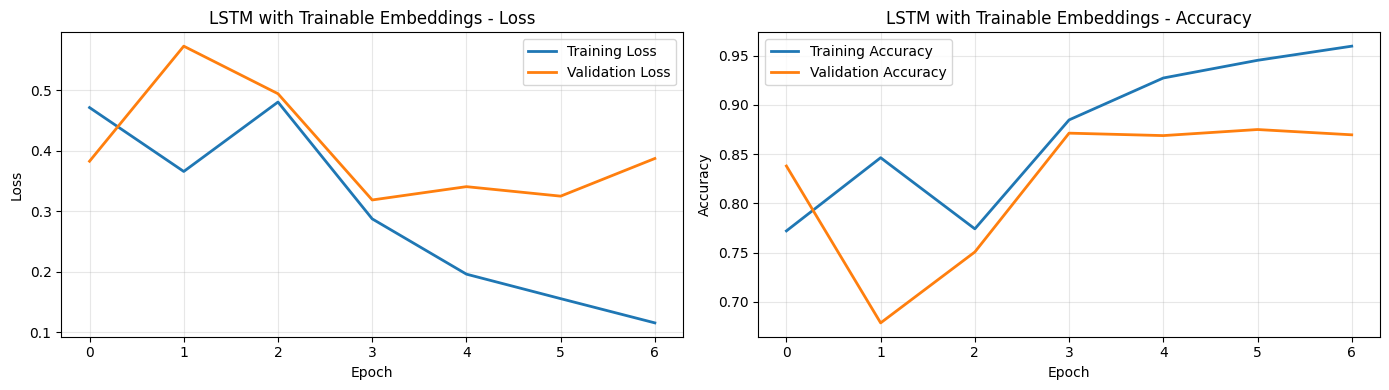

In [ ]:
# Plot training history
plot_training_history(history_trainable, title="LSTM with Trainable Embeddings")

## 4. Model 2: LSTM with Pre-trained GloVe Embeddings

Now we use pre-trained GloVe word vectors instead of learning embeddings from scratch. GloVe vectors were trained on a large corpus (Wikipedia + Gigaword) and capture semantic relationships between words.

In [ ]:
glove_path = download_glove_embeddings(glove_dim=EMBEDDING_DIM)

GloVe embeddings already exist at /Users/philippgeppner/.keras/datasets/glove.6B.100d.txt


In [ ]:
embedding_matrix = create_embedding_matrix_from_glove(
    glove_path=glove_path,
    word_index=word_index,
    embedding_dim=EMBEDDING_DIM,
    num_words=MAX_WORDS
)

Loading GloVe embeddings from /Users/philippgeppner/.keras/datasets/glove.6B.100d.txt...
Loaded 400,000 word vectors
Matched 9,793 words (98.0% coverage)
Sample missing words: ["else's", "miyazaki's", "victoria's", "paul's", "chan's", "show's", "wife's", "character's", "hadn't", "isn't"]


### Create and Train GloVe Model

We set `trainable_embeddings=False` to freeze the pre-trained embeddings during training (pure transfer learning). You could also set it to `True` to fine-tune the embeddings.

In [ ]:
model_glove = keras.models.Sequential([
    keras.layers.Input(shape=(MAX_LEN,)),
    keras.layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        trainable=False,  # Freeze pre-trained embeddings
        mask_zero=True
    ),
    keras.layers.LSTM(LSTM_UNITS,dropout=0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model_glove.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_glove.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 500, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,501 (4.12 MB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
model_glove, history_glove = train_model(
    model=model_glove,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="lstm_glove_embedding",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    early_stopping=True,
    patience=3
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 94s 238ms/step - accuracy: 0.6637 - loss: 0.6074 - val_accuracy: 0.6754 - val_loss: 0.6167
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 98s 251ms/step - accuracy: 0.7694 - loss: 0.4901 - val_accuracy: 0.8147 - val_loss: 0.4135
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 94s 242ms/step - accuracy: 0.8209 - loss: 0.4015 - val_accuracy: 0.8467 - val_loss: 0.3551
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 244ms/step - accuracy: 0.8395 - loss: 0.3673 - val_accuracy: 0.8598 - val_loss: 0.3204
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 94s 241ms/step - accuracy: 0.8502 - loss: 0.3455 - val_accuracy: 0.8677 - val_loss: 0.3159
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 246ms/step - accuracy: 0.8554 - loss: 0.3322 - val_accuracy: 0.8635 - val_loss: 0.3157
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 245ms/step - accuracy: 0.8632 - loss: 0.3205 - val_accuracy: 0.8776 - val_loss: 0.2915
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 243ms/step - accuracy: 0.8704 - loss: 0

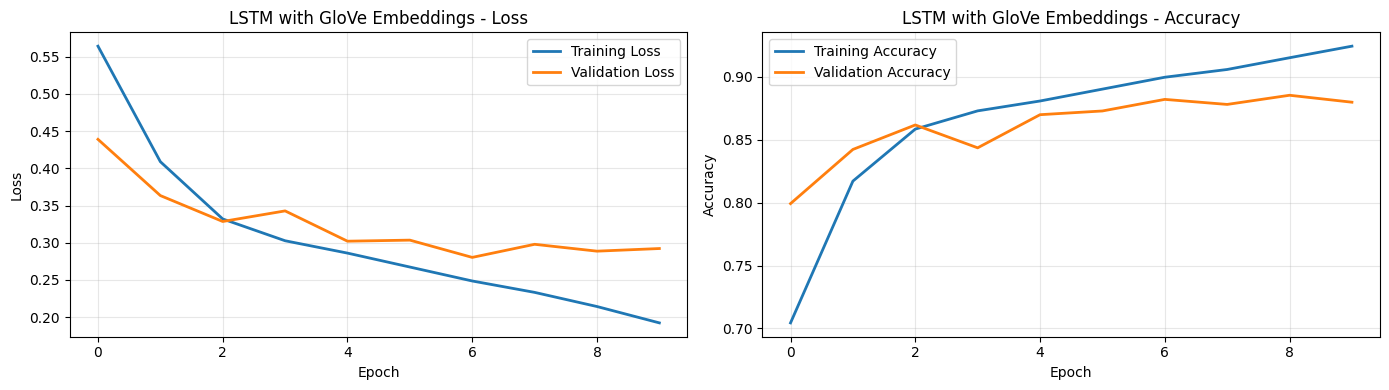

In [ ]:
# Plot training history
plot_training_history(history_glove, title="LSTM with GloVe Embeddings")

## 5. Evaluate on Hold-out Test Set

Now we evaluate both models on the hold-out test set to compare their performance.

EVALUATING MODEL 1: LSTM WITH TRAINABLE EMBEDDINGS

  LSTM + Trainable Embeddings - Binary Classification Results
  Test Loss:     0.3082
  Test Accuracy: 0.8731 (87.31%)

              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      6184
    Positive       0.87      0.88      0.88      6316

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



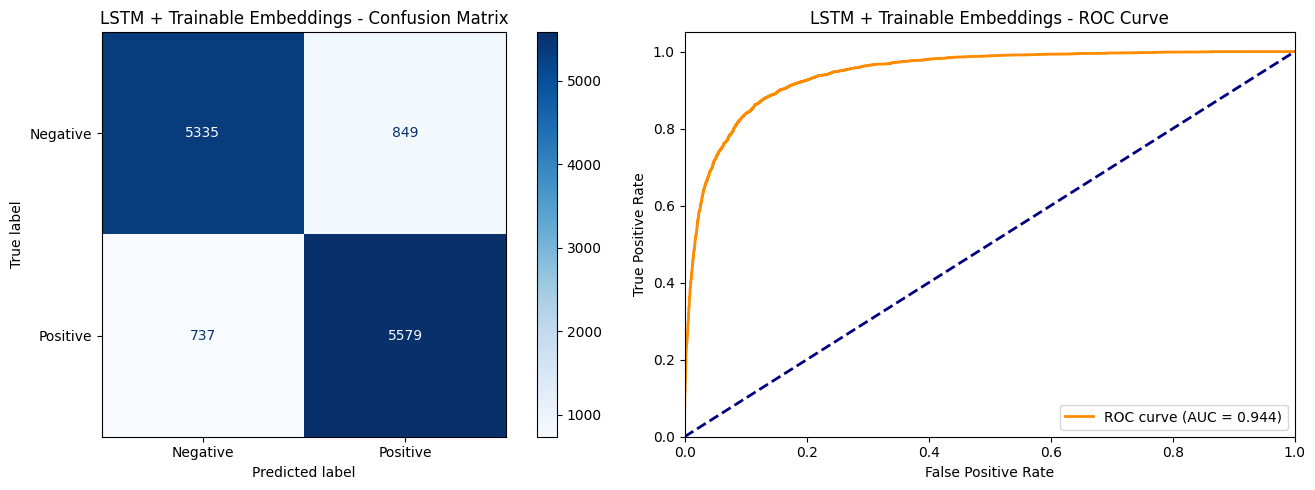

In [ ]:
print("=" * 70)
print("EVALUATING MODEL 1: LSTM WITH TRAINABLE EMBEDDINGS")
print("=" * 70)
loss_trainable, acc_trainable = eval_binary_classification(
    model_trainable, X_test, y_test, 
    model_name="LSTM + Trainable Embeddings"
)

EVALUATING MODEL 2: LSTM WITH GLOVE EMBEDDINGS

  LSTM + GloVe Embeddings - Binary Classification Results
  Test Loss:     0.2671
  Test Accuracy: 0.8895 (88.95%)

              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      6184
    Positive       0.89      0.89      0.89      6316

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



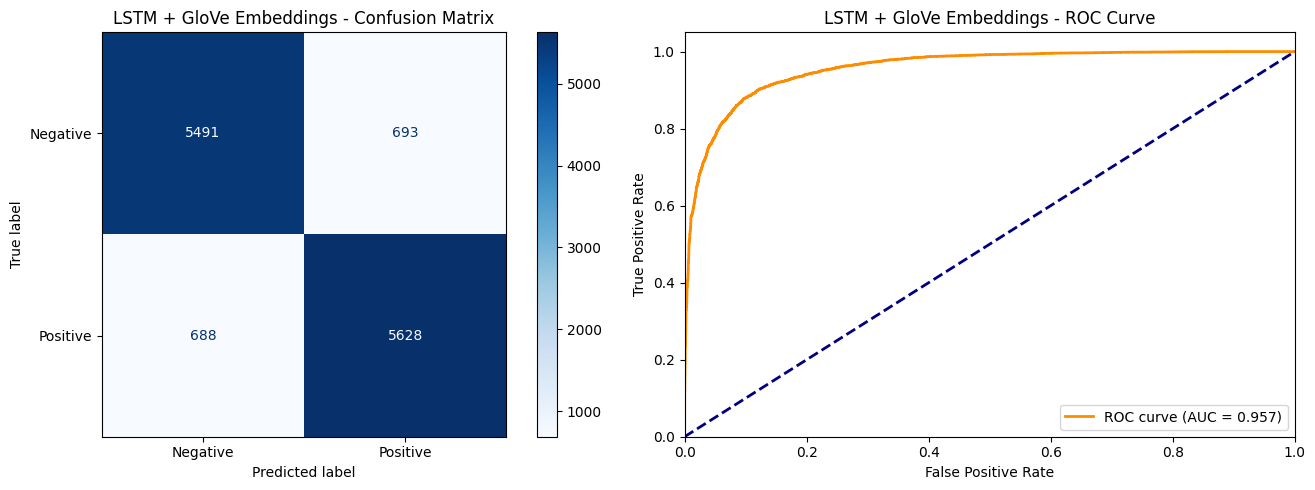

In [ ]:
print("=" * 70)
print("EVALUATING MODEL 2: LSTM WITH GLOVE EMBEDDINGS")
print("=" * 70)
loss_glove, acc_glove = eval_binary_classification(
    model_glove, X_test, y_test, 
    model_name="LSTM + GloVe Embeddings"
)

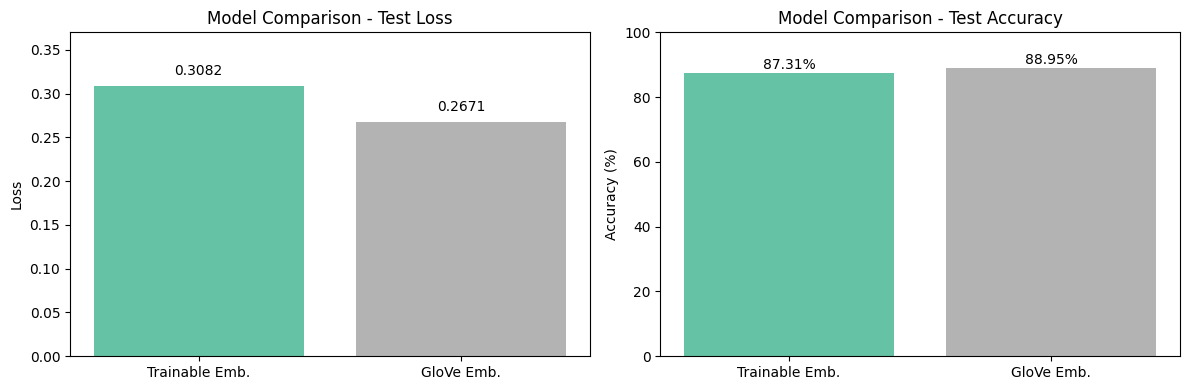

In [ ]:
# Compare both models
results = {
    "Trainable Emb.": (loss_trainable, acc_trainable),
    "GloVe Emb.": (loss_glove, acc_glove)
}
compare_models(results)

In [ ]:
import pandas as pd
summary_df = pd.DataFrame({
    'Model': ['Trainable Embeddings', 'GloVe Embeddings'],
    'Test Loss': [loss_trainable, loss_glove],
    'Test Accuracy': [f"{acc_trainable*100:.2f}%", f"{acc_glove*100:.2f}%"]
})
summary_df

,Model,Test Loss,Test Accuracy
0,Trainable Embeddings,0.308215,87.31%
1,GloVe Embeddings,0.267053,88.95%


## 6. Test on Custom Reviews

Let's test both models on some custom reviews to see how they perform in practice.

In [ ]:
my_reviews = [
    "this is probably the worst movie i have seen in my entire life it really sucks",
    "great movie wow i really really liked it would highly recommend",
    "it was an incredible experience and i would watch it again without second thought",
    "complete trash show wasted money if you ask me",
    "it was more or less good but nothing special",
    "What a disaster of a movie – a disaster for anyone hoping to dislike it. Witty, captivating, the best of the decade.",
    "A horrible movie – horribly witty and captivating, that is. The defining movie of this decade.",
    "In my opinion this is really not a bad watch",
    "This movie is not good.",
    "enjoyable and thrilling - if you have the brain capacity of a 5 year old child",
]

def encode_review(text, word_index, maxlen=500, num_words=10000):
    words = text.lower().split()
    encoded = [1]  # Start token
    for word in words:
        idx = word_index.get(word, 2)  # 2 is OOV
        if idx < num_words - 3:
            encoded.append(idx + 3)  # Shift by 3 for special tokens
        else:
            encoded.append(2)  # OOV
    # Pad/truncate to maxlen
    if len(encoded) < maxlen:
        encoded = [0] * (maxlen - len(encoded)) + encoded
    else:
        encoded = encoded[:maxlen]
    return np.array(encoded)

custom_data = np.array([encode_review(r, word_index, MAX_LEN, MAX_WORDS) for r in my_reviews])

pred_trainable = model_trainable.predict(custom_data, verbose=0).flatten()
pred_glove = model_glove.predict(custom_data, verbose=0).flatten()

results_df = pd.DataFrame({
    'Review': [r[:60] + '...' if len(r) > 60 else r for r in my_reviews],
    'Trainable': [f"{'Pos' if p > 0.5 else 'Neg'} ({p:.2f})" for p in pred_trainable],
    'GloVe': [f"{'Pos' if p > 0.5 else 'Neg'} ({p:.2f})" for p in pred_glove]
})
results_df


,Review,Trainable,GloVe
0,this is probably the worst movie i have seen i...,Neg (0.02),Neg (0.05)
1,great movie wow i really really liked it would...,Pos (1.00),Pos (0.99)
2,it was an incredible experience and i would wa...,Pos (0.94),Pos (0.95)
3,complete trash show wasted money if you ask me,Neg (0.05),Neg (0.03)
4,it was more or less good but nothing special,Pos (0.71),Neg (0.38)
5,What a disaster of a movie – a disaster for an...,Pos (0.72),Neg (0.19)
6,A horrible movie – horribly witty and captivat...,Neg (0.33),Neg (0.09)
7,In my opinion this is really not a bad watch,Neg (0.26),Neg (0.31)
8,This movie is not good.,Pos (0.65),Neg (0.42)
9,enjoyable and thrilling - if you have the brai...,Pos (0.92),Pos (0.95)
